<center> <h1>Homework 8 | DATA 5600</h1> </center>
<center> <h2>PCA and PCR</h2> </center>
<center> <h3> Dallin Moore <h3> <center>

In [1]:
# load packages here
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from sklearn.linear_model import LinearRegression

from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# set seed
import random
random.seed(5600)

# hide convergence warnings
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

## Data and Description

This [data](https://github.com/nevernervous78/nirpyresearch/tree/master/data) and information comes from a blog called [Nirpy Research](https://nirpyresearch.com/). The observations in the data come from 50 fresh peaches. The goal of the analysis is to determine if information from near-infrared (NIR) spectroscopy (a non-invasive technique used to measure the concentration of compounds in a substance by analyzing the absorption of near-infrared light) can be used as a substitute measurement for "Brix," the response variable, which is the measure of the sugar content in a peach. Note that the Brix column was measured using a technique other than NIR that is more invasive. Being able to accurately measure a peach's sugar content can help "establish the eating quality of the fruit, and therefore its market value."

The blog states that "Typical NIR spectra are acquired at many wavelengths. For instance, with our Luminar 5030 we typically acquire 601 wavelength points with an interval of 2 nm. That means each scan will contain 601 variables. When we want to relate a NIR scan with a specific chemical or physical parameter of our sample, we generally do not need these many variables. Often just a handful of independent variables are sufficient to describe the action of the parameter of interest on our spectrum." This is a great use-case for PCR! 

To summarize, the data set has 50 observations (peaches), the response variable is Brix (the sugar content of a peach), and there are 600 predictor variables (wavelengths obtained from NIR spectroscopy).

The data can be found in Files -> DATA SETS on Canvas. Download peach_spectra_brix.csv, and put it in the same folder as this file.

### <span style="color:blue">**Note that you will fit 3 models in this assignment. For sake of time, we are not checking the model assumptions, but you would certainly check assumptions in "real life."**


#### 1. Read in the data set and call it "peach". Print the first few rows of the data, along with a summary of the data, to make sure the data makes sense. [2 points]

In [2]:
peach = pd.read_csv('peach_spectra_brix.csv')
peach.head()

,Brix,wl1,wl2,wl3,wl4,wl5,wl6,wl7,wl8,wl9,...,wl591,wl592,wl593,wl594,wl595,wl596,wl597,wl598,wl599,wl600
0,15.5,-1.032355,-1.030551,-1.027970,-1.024937,-1.021866,-1.019143,-1.016866,-1.014910,-1.012907,...,0.692447,0.692944,0.692376,0.690764,0.688081,0.684294,0.679348,0.673240,0.665922,0.657307
1,16.7,-1.139034,-1.137186,-1.134485,-1.131222,-1.127761,-1.124464,-1.121508,-1.118802,-1.115973,...,0.729328,0.728031,0.725548,0.721815,0.716767,0.710405,0.702706,0.693710,0.683480,0.671960
2,18.1,-1.152821,-1.150937,-1.148288,-1.145165,-1.141951,-1.138977,-1.136366,-1.134011,-1.131516,...,0.736608,0.735214,0.732669,0.728911,0.723844,0.717415,0.709645,0.700555,0.690147,0.678390
3,14.8,-1.087215,-1.085455,-1.082867,-1.079797,-1.076568,-1.073632,-1.071087,-1.068877,-1.066654,...,0.758695,0.757963,0.756038,0.752903,0.748496,0.742886,0.736085,0.728019,0.718577,0.707702
4,15.1,-1.080364,-1.078436,-1.075784,-1.072693,-1.069562,-1.066691,-1.064214,-1.062025,-1.059787,...,0.719793,0.718875,0.716860,0.713771,0.709577,0.704232,0.697717,0.689882,0.680748,0.670263


#### 2. Approximately how many predictor variables can the number of observations in this data set support in a traditional regression model? In other words, what is the maximum number of variables you would feel comfortable including in a regression model, given the number of observations in this data set? [1 point]

In [5]:
num_obs = peach.shape[0]
print(f"Number of observations: {num_obs}")
print(f"The data can support between {num_obs // 20} and {num_obs // 10} predictor variables.")

Number of observations: 50
The data can support between 2 and 5 predictor variables.


A rule of thumb is to have at least 10-20 observations per predictor variable. Given that there are 50 observations, a typical multiple linear regression could support between 2 and 5 predictor variables. 

#### 3. Split the data into "y" (the response) and "X" (a data frame holding the wavelength predictors) [1 point]

In [6]:
# Split the data into y and X
y = peach['Brix']
X = peach.drop(columns=['Brix'])
X.shape

(50, 600)

#### 4. Create a correlation matrix for the wavelengths (X) - not a heatmap/colored matrix, just the numeric one. Note that not all values will be displayed due to the size of the data set. After skimming the results, do you anticipate problems with multicollinearity based on these results? Why or why not? [1 point]

In [7]:
correlation_matrix = X.corr()
correlation_matrix

,wl1,wl2,wl3,wl4,wl5,wl6,wl7,wl8,wl9,wl10,...,wl591,wl592,wl593,wl594,wl595,wl596,wl597,wl598,wl599,wl600
wl1,1.000000,1.000000,0.999999,0.999997,0.999991,0.999978,0.999956,0.999921,0.999871,0.999801,...,-0.774144,-0.771260,-0.766456,-0.759217,-0.748944,-0.735011,-0.716910,-0.693634,-0.664679,-0.628655
wl2,1.000000,1.000000,1.000000,0.999998,0.999992,0.999980,0.999959,0.999925,0.999876,0.999807,...,-0.774238,-0.771359,-0.766560,-0.759327,-0.749059,-0.735133,-0.717038,-0.693770,-0.664823,-0.628807
wl3,0.999999,1.000000,1.000000,0.999999,0.999995,0.999985,0.999965,0.999933,0.999886,0.999819,...,-0.774408,-0.771538,-0.766749,-0.759527,-0.749271,-0.735358,-0.717277,-0.694023,-0.665092,-0.629091
wl4,0.999997,0.999998,0.999999,1.000000,0.999998,0.999991,0.999975,0.999946,0.999904,0.999842,...,-0.774697,-0.771844,-0.767074,-0.759872,-0.749639,-0.735749,-0.717693,-0.694466,-0.665563,-0.629592
wl5,0.999991,0.999992,0.999995,0.999998,1.000000,0.999997,0.999986,0.999964,0.999927,0.999872,...,-0.775081,-0.772253,-0.767509,-0.760335,-0.750133,-0.736277,-0.718256,-0.695067,-0.666203,-0.630273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
wl596,-0.735011,-0.735133,-0.735358,-0.735749,-0.736277,-0.736998,-0.737845,-0.738820,-0.739910,-0.741068,...,0.991684,0.994127,0.996305,0.998149,0.999472,1.000000,0.999327,0.996912,0.992081,0.983848
wl597,-0.716910,-0.717038,-0.717277,-0.717693,-0.718256,-0.719024,-0.719925,-0.720962,-0.722118,-0.723350,...,0.986511,0.989617,0.992553,0.995275,0.997616,0.999327,1.000000,0.999117,0.995998,0.989686
wl598,-0.693634,-0.693770,-0.694023,-0.694466,-0.695067,-0.695884,-0.696842,-0.697945,-0.699173,-0.700483,...,0.979107,0.982932,0.986696,0.990390,0.993866,0.996912,0.999117,1.000000,0.998870,0.994808
wl599,-0.664679,-0.664823,-0.665092,-0.665563,-0.666203,-0.667072,-0.668089,-0.669260,-0.670561,-0.671954,...,0.968845,0.973436,0.978091,0.982839,0.987560,0.992081,0.995998,0.998870,1.000000,0.998517


If this was regular regression, multicollinearity would be a huge concern. There are extremely high values. Luckily, with PCR it inherently accounts for multicollinearity so there is nothing that we will need to do.

#### 5. Breifly explain why principal component regression (PCR) could be a good model to apply to this data set. [1 point]

The dataset includes only 50 observations but an exceptionally high number of predictor variables; such a high dimensionality compared to the sample size makes traditional regression unsuitable, as it would result in overfitting and would violate the assumption of multicollinearity among the predictors. PCR addresses this challenge by reducing the dimensionality of the data through PCA, transforming the original 600 correlated predictor variables into a smaller set of uncorrelated principal components, which summarize the most important variance in the data. 


#### 6. Throughout this assignment, we will work with standardized wavelengths (helps computationally). Standardize the wavelengths (the X data frame). [1 point]

In [8]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler to the data and transform it
X_standardized = scaler.fit_transform(X)

# Convert the standardized data back to a DataFrame
X_standardized = pd.DataFrame(X_standardized, columns=X.columns)

X_standardized.head()

,wl1,wl2,wl3,wl4,wl5,wl6,wl7,wl8,wl9,wl10,...,wl591,wl592,wl593,wl594,wl595,wl596,wl597,wl598,wl599,wl600
0,0.201194,0.200793,0.200285,0.199272,0.197609,0.195164,0.192390,0.189258,0.185860,0.181615,...,-0.975429,-0.924616,-0.876725,-0.829273,-0.781976,-0.734005,-0.685710,-0.635490,-0.583346,-0.531244
1,-1.109162,-1.109354,-1.109110,-1.108460,-1.107046,-1.104759,-1.102016,-1.099208,-1.096130,-1.093311,...,0.543270,0.534894,0.523145,0.506017,0.481527,0.449885,0.409955,0.363538,0.313278,0.256375
2,-1.278519,-1.278312,-1.278787,-1.280010,-1.281875,-1.283887,-1.285812,-1.287829,-1.289455,-1.291128,...,0.843065,0.833660,0.823684,0.811130,0.793210,0.767693,0.735470,0.697590,0.653776,0.602046
3,-0.472664,-0.473775,-0.474571,-0.475720,-0.476337,-0.477361,-0.478311,-0.480043,-0.482675,-0.485916,...,1.752580,1.779957,1.809867,1.842829,1.879040,1.922539,1.975683,2.037951,2.105645,2.177621
4,-0.388503,-0.387544,-0.387490,-0.388323,-0.390017,-0.391697,-0.393294,-0.395064,-0.397253,-0.400014,...,0.150642,0.154022,0.156528,0.160106,0.164850,0.170011,0.175939,0.176732,0.173759,0.165162


#### 7. Fit a linear regression model with an intercept ONLY. This is equivalent to using the mean of Y as the predicted value for all peaches. We will use this model as our baseline model. Obtain the following from the model, and put the values in the table below under the "Intercept-Only Linear Regression" column: (a) adjusted $ R^2 $, (b) AIC, (c) BIC, and (d) MSE. [2 points]
<span style="color:blue">**NOTE: Round the values to something sensible in the table (at most 2 decimals)**

In [9]:
# Fit the intercept-only model
model_intercept_only = sm.OLS(y, sm.add_constant([1] * len(y))).fit()

# Print results
print(f"Adjusted R^2: {model_intercept_only.rsquared_adj:.2f}")
print(f"BIC: {model_intercept_only.bic:.2f}")
print(f"AIC: {model_intercept_only.aic:.2f}")
print(f"MSE: {model_intercept_only.mse_resid:.2f}")

Adjusted R^2: 0.00
BIC: 222.75
AIC: 220.84
MSE: 4.75


In [10]:
selection_data = {'Intercept-Only Linear Regression':      ['0.00', '222.75', '220.84', '4.75'],
                  'LASSO Linear Regression':               ['', '', '', ''],
                  'Principal Component Linear Regression': ['', '', '', '']}

row_names = ['Adj. R-Squared', 'BIC', 'AIC', 'MSE']

selection_table = pd.DataFrame(selection_data, index = row_names)
selection_table = selection_table.style.set_properties(**{'text-align': 'center'})
selection_table

selection_data = {'Adj. R-Squared': ['0.00', '', ''],
                  'BIC':            ['222.75', '', ''],
                  'AIC':            ['220.84', '', ''],
                  'MSE':            ['4.75', '', '']}

row_names = ['Intercept-Only Linear Regression', 'LASSO Linear Regression', 'Principal Component Linear Regression']

selection_table = pd.DataFrame(selection_data, index = row_names)
selection_table_pretty = selection_table.style.set_properties(**{'text-align': 'center'})
selection_table_pretty

,Adj. R-Squared,BIC,AIC,MSE
Intercept-Only Linear Regression,0.00,222.75,220.84,4.75
LASSO Linear Regression,,,,
Principal Component Linear Regression,,,,


#### 8. As we did in Module 5, apply LASSO to this data set using the PMSE metric (`neg_mean_squared_error`) with cv = 5. Do the following: (a) Output the lambda (called alpha in the code) coefficient value corresponding to the 1 standard error rule, and (b) output the variable names that have non-zero coefficients resulting from LASSO with lambda equal to the value obtained in (a). [2 points]
<span style="color:blue">**NOTE: use this code when creating a list of potential_alphas: np.logspace(-1.5, -0.5, 500)**. This code reduces the range of lambda values from what we used previously to help with convergence issues. Note that you might still get one convergence warning, but you can ignore it.

In [11]:
# Define the range of potential alpha (lambda) values
potential_alphas = np.logspace(-1.5, -0.5, 500)

# Initialize LASSO with cross-validation
LASSOCV_model = LassoCV(alphas=potential_alphas, 
                        cv=5, 
                        random_state=12345, 
                        max_iter=10000, 
                        fit_intercept=True)

# Fit the model
LASSOCV_model.fit(X_standardized, y)

# Get the list of alphas and corresponding PMSEs
alphas = LASSOCV_model.alphas_  # The range of alphas considered
pmse_means = np.mean(LASSOCV_model.mse_path_, axis=1)  # Mean PMSE for each alpha
pmse_std_error = np.std(LASSOCV_model.mse_path_, axis=1, ddof=1) / np.sqrt(5)  # Standard error

# Find the alpha that minimizes PMSE
alpha_index_min = np.argmin(pmse_means)  # Index of minimum PMSE

# Calculate the threshold for the 1-SE rule
one_se_above_min = pmse_means[alpha_index_min] + pmse_std_error[alpha_index_min]

# Find the largest alpha with PMSE within one SE of the minimum
alpha_index_1se = np.where(pmse_means <= one_se_above_min)[0][-1]  # Use the largest alpha
alpha_1se = alphas[alpha_index_1se]

print("Alpha using 1-SE rule:", alpha_1se)

LASSO_1se = Lasso(alpha = alpha_1se,
                   fit_intercept = True)
LASSO_1se.fit(X_standardized, y)

# Filter non-zero coefficients and their corresponding variable names
non_zero_indices = np.where(LASSO_1se.coef_ != 0)[0]  # Indices of non-zero coefficients
non_zero_variables = X_standardized.columns[non_zero_indices]      # Variable names corresponding to non-zero coefficients
non_zero_coefficients = LASSO_1se.coef_[non_zero_indices]  # Non-zero coefficient values

# Print the result
print("Variables kept and coefficients:")
print(*(list(zip(non_zero_variables, non_zero_coefficients))), sep="\n")


Alpha using 1-SE rule: 0.03162277660168379
Variables kept and coefficients:
('wl146', -0.547059117416022)
('wl147', -0.8532949725866871)
('wl235', 0.03577160207466789)
('wl236', 0.8262961801558169)
('wl237', 0.48551329422659706)
('wl238', 0.12390188199227542)
('wl239', 0.006596814675272515)
('wl315', 0.7190622715882355)
('wl316', 0.3625458627859234)
('wl381', -0.9344518158622954)
('wl534', 0.14370463392986796)
('wl535', 0.8837472049426199)
('wl536', 0.9633090066111051)
('wl537', 0.7440409935018042)
('wl538', 0.052166759543361904)
('wl579', -0.9579475440866828)
('wl580', -0.7356405948803187)


#### 9. Now that you have a subset of wavelengths that are likely "important," fit a linear regression model using those wavelengths as predictors. Print a summary of the model results. Also, obtain the following from the model, and put the values in the table below under the "LASSO Linear Regression" column: (a) adjusted R$^2$, (b) AIC, (c) BIC, and (d) MSE. [2 points]
<span style="color:blue">**NOTE: Copy/paste the values you obtained for the "Intercept-Only Linear Regression" column, as well, so this table should have two columns with values.**

In [12]:
# Fit the intercept-only model
model_lasso = sm.OLS(y, X_standardized[non_zero_variables]).fit()

# Print results
print(f"Adjusted R^2: {model_lasso.rsquared_adj:.2f}")
print(f"BIC: {model_lasso.bic:.2f}")
print(f"AIC: {model_lasso.aic:.2f}")
print(f"MSE: {model_lasso.mse_resid:.2f}")

Adjusted R^2: -0.50
BIC: 488.59
AIC: 456.08
MSE: 411.30


In [ ]:
# adjusted R^2, BIC, AIC, MSE
selection_table.loc['LASSO Linear Regression'] = ['-0.50', '488.59', '456.08', '411.30']
selection_table_pretty

,Adj. R-Squared,BIC,AIC,MSE
Intercept-Only Linear Regression,0.00,222.75,220.84,4.75
LASSO Linear Regression,-0.50,488.59,456.08,411.30
Principal Component Linear Regression,,,,


#### 10. Compare the "Intercept-Only Linear Regression" model results with the "LASSO Linear Regression" results. Which one performs better? Does it perform better across all metrics or just some?  [1 point]

A higher adjusted $ R^2 $ indicates a better fit. Lower values of BIC and AIC indicate better model performance, so the intercept-only model outperforms LASSO in both BIC and AIC. Lower MSE indicates better predictive accuracy. The intercept-only model has a much lower MSE, suggesting it performs better in this metric as well.

#### 11. Before we apply PCR, let's better understand the data by applying PCA. Create a scree plot showing results for 1 to 50 principal components. Also, create the corresponding "Cumulative Proportion of Variance Explained" plot.  [2 point]

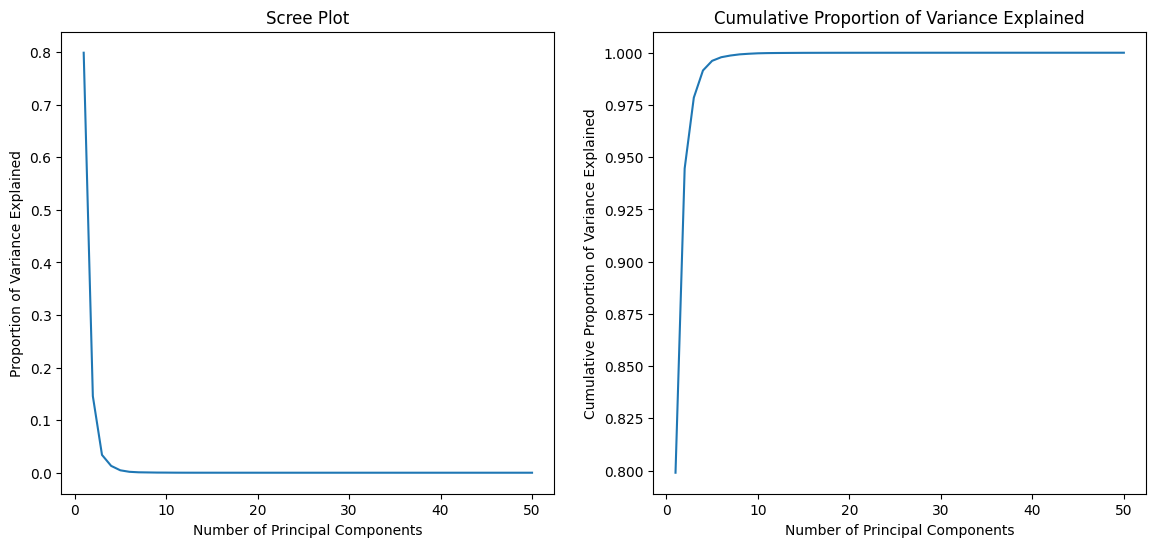

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Scree Plot
num_components = min(X_standardized.shape[0], X_standardized.shape[1])
sns.lineplot(ax=axes[0], x=np.arange(1, num_components + 1), 
             y=pca.explained_variance_ratio_[:num_components])
axes[0].set_xlabel("Number of Principal Components")
axes[0].set_ylabel("Proportion of Variance Explained")
axes[0].set_title("Scree Plot")

# Cumulative Proportion of Variance Explained Plot
sns.lineplot(ax=axes[1], x=np.arange(1, num_components + 1), 
             y=np.cumsum(pca.explained_variance_ratio_[:num_components]))
axes[1].set_xlabel("Number of Principal Components")
axes[1].set_ylabel("Cumulative Proportion of Variance Explained")
axes[1].set_title("Cumulative Proportion of Variance Explained")

plt.show()


#### 12. What is the miniumum number of principal components needed to explain more than 99% of the variability in the wavelength data? [1 point]

In [21]:
# extract the x given a y of 0.99 for the Cumulative Proportion of Variance Explained Plot
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
num_components = np.where(cumulative_variance > 0.99)[0][0] + 1
num_components

4

To explain 99% of the variability, a minimum of 4 principal components would be required.

#### 13. Based on the PCA results, about how many principal components do you think we will end up including in your PCR model? Why? [1 point]

Given that only 4 principal components can explain 99% of the variability, I don't think that there will be the need for any more than 4.

#### 14. We will now apply PCR to the data. First, we need to determine the number of principal components to include in the model, and we will do this based on cross-validation (not based on the scree plot from above). Create a plot with the MSE on the y-axis and the number of principal components used on the x-axis, as obtained from cross-validation. [1 point]
<span style="color:blue">**NOTE: To reduce computation time (and since we know from our PCA analysis that only a small number of components are likely needed), change the upperbound of the number of components to be something reasonable based on the PCA analysis. You'll want to choose a value that is at least three times more than you think you'll need (to be safe) but much less than 50. You will change this code:**
    
<span style="color:blue">param_grid = {"reduce_dim__n_components": list(range(1, *** + 1))}    
    
<span style="color:blue">**(where *** is the maximum number of components you choose).**

In [22]:
def lower_bound(cv_results):
    best_score_idx = np.argmin(-cv_results["mean_test_score"])  # find minimum position of (positive) MSEs
    return (
        -cv_results["mean_test_score"][best_score_idx]
        + (cv_results["std_test_score"][best_score_idx] / np.sqrt(5))  # 5-fold CV
    )

# Balance model complexity with cross-validated score.
def best_low_complexity(cv_results):
    threshold = lower_bound(cv_results)  # pass in (positive) MSEs
    candidate_idx = np.flatnonzero(-cv_results["mean_test_score"] <= threshold)
    best_idx = candidate_idx[
        cv_results["param_reduce_dim__n_components"][candidate_idx].argmin()
    ]
    return best_idx

pipe = Pipeline(
    [
        ("reduce_dim", PCA(random_state = 42)),
        ("linear_model", LinearRegression(fit_intercept = True)),
    ]
)

param_grid = {"reduce_dim__n_components": list(range(1, 12 + 1))} # 1 to 12 components, 12 is 3 times the number of predictors we expect based on PCA

# 5-fold cross validation to choose the number of components
grid = GridSearchCV(
    pipe,
    cv = 5,
    n_jobs = 1,
    param_grid = param_grid,
    scoring = "neg_mean_squared_error",  # can use "accuracy" for binary response
    refit = best_low_complexity, 
)

grid.fit(X, y)

n_components = grid.cv_results_["param_reduce_dim__n_components"]
test_scores = -grid.cv_results_["mean_test_score"]  # get positive MSE

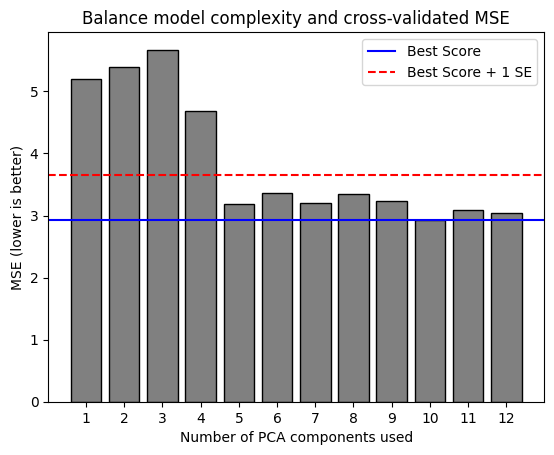

In [23]:
plt.figure()
plt.bar(n_components, 
        test_scores, 
        color = "grey",
        edgecolor = 'black')

lower = lower_bound(grid.cv_results_)
plt.axhline(np.min(test_scores), 
            linestyle = "-", 
            color = "blue", 
            label = "Best Score")
plt.axhline(lower, 
            linestyle = "--",
            color = "red", 
            label = "Best Score + 1 SE")

plt.title("Balance model complexity and cross-validated MSE")
plt.xlabel("Number of PCA components used")
plt.ylabel("MSE (lower is better)")
plt.xticks(n_components.tolist())
plt.legend(loc = "upper right")
plt.show()

In [24]:
print(n_components[np.argmin(test_scores)], "components yields the best (lowest) MSE")
best_index_ = grid.best_index_
print(n_components[best_index_], "components are selected based on the 1 SE rule")

10 components yields the best (lowest) MSE
5 components are selected based on the 1 SE rule


#### 15. Based on the cross-validation results, how many principal components would you include in a regression model? Do these results surprise you at all compared to what PCA exploratory data analysis revealed, or are results similar to what you expected? [1 point]

The result found that 5 components should be chosen with the 1 SE rule. This is not surprising given that with PCA I predicted that the number of principal components would be 4. 

#### 16. Now, fit a PCR model using the number of components that correpsonds to the 1 SE rule. Print a summary of the model results. Also, obtain the following from the model, and put the values in the table below under the "Principal Component Linear Regression" column: (a) adjusted $R^2$ , (b) AIC, (c) BIC, and (d) MSE. [2 points]
<span style="color:blue">**NOTE: Copy/paste the values you obtained for the "Intercept-Only Linear Regression" and "LASSO Linear Regression" columns, as well, so this table should be completely filled out.**

In [26]:
pca_5 = PCA(n_components = 5).fit(X_standardized)
pc_5 = pca_5.transform(X_standardized)
X_pca_5 = sm.add_constant(pc_5)
mod_pca_5 = sm.OLS(y, X_pca_5).fit()
mod_pca_5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Brix   R-squared:                       0.464
Model:                            OLS   Adj. R-squared:                  0.403
Method:                 Least Squares   F-statistic:                     7.623
Date:                Thu, 05 Dec 2024   Prob (F-statistic):           3.14e-05
Time:                        16:37:52   Log-Likelihood:                -93.822
No. Observations:                  50   AIC:                             199.6
Df Residuals:                      44   BIC:                             211.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         16.4360      0.238     68.997      0.000      15.956      16.916
x1            -0.0017      0.011     -0.161      0.873      -0.024       0.020
x2             0.0143      0.025      0.562      0.577      -0.037       0.066
x3             0.1095      0.053      2.073      0.044       0.003       0.216
x4            -0.4305      0.085     -5.051      0.000      -0.602      -0.259
x5            -0.4040      0.143     -2.821      0.007      -0.693      -0.115
==============================================================================
Omnibus:                       21.307   Durbin-Watson:                   2.313
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               36.113
Skew:                          -1.305   Prob(JB):                     1.44e-08
Kurtosis:                       6.245   Cond. No.                         21.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [27]:
print(f"Adjusted R^2: {mod_pca_5.rsquared_adj:.2f}")
print(f"BIC: {mod_pca_5.bic:.2f}")
print(f"AIC: {mod_pca_5.aic:.2f}")
print(f"MSE: {mod_pca_5.mse_resid:.2f}")

Adjusted R^2: 0.40
BIC: 211.12
AIC: 199.64
MSE: 2.84


In [28]:
# adjusted R^2, BIC, AIC, MSE
selection_table.loc['Principal Component Linear Regression'] = ['0.40', '211.12', '199.64', '2.84']
selection_table_pretty

,Adj. R-Squared,BIC,AIC,MSE
Intercept-Only Linear Regression,0.00,222.75,220.84,4.75
LASSO Linear Regression,-0.50,488.59,456.08,411.30
Principal Component Linear Regression,0.40,211.12,199.64,2.84


#### 17. Compare the three models. Which model performs the "best"? Does it perform better across all metrics or just some? [1 point]

Principal Component Linear Regression performs the best across all metrics. It has the highest adjusted $ R^2 $, lowest BIC, lowest AIC, and lowest MSE (Lower MSE is better as it indicates less prediction error), indicating that it strikes the best balance between explanatory power, model complexity, and predictive accuracy. 

The Intercept-Only model performs better than LASSO but is inferior to Principal Component Regression in every metric. LASSO performs poorly across all metrics, suggesting it is not a good fit for this dataset.

#### 18. If you were to proceed with this analysis, which model would you use and why? [1 point]

I would the use the PCR model because it is performing the best as seen in the last question.

#### 19. Briefly summarize what you learned from this analysis *to a non-statistician*. Write a few sentences about (1) the purpose of this data set and analysis and (2) what you learned about this data set from your analysis. Write your response as if you were addressing a business manager (avoid using statistics jargon) and just provide the main take-aways. [2 points]

The purpose of this analysis was to determine if we could use non-invasive near-infrared spectroscopy data to predict the sugar content (Brix) of peaches. This would help in assessing the quality and market value of the fruit without damaging it. From the analysis, we found that using Principal Component Regression (PCR) provided the best model for predicting the sugar content. This model effectively reduced the complexity of the data while maintaining accuracy, making it a valuable tool for non-invasive quality assessment in the fruit industry.

